## A quick look at the December 2019 ap_pipe rerun

Now with templates at the instrumental DECam resolution, still with a nominal "best seeing" selection!

In [1]:
%matplotlib notebook
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import importlib

import lsst.daf.persistence as dafPersist
import lsst.geom
import lsst.pipe.base as pipeBase

In [16]:
sys.path.append('/project/mrawls/good_life_choices/ap_pipe-notebooks/')  # bleeding edge branch
from diaObjectAnalysis import loadAllApdbObjects, loadAllApdbSources, plotDiaObjectHistogram #, setObjectFilter
import plotLightcurve as plc  # in_ipynb, loadApdbObjects, loadApdbSources, patchFinder, plotLightcurve
from apdbPlots import makeSrcTableFlags

In [ ]:
# Only if you change anything in the code imported above
importlib.reload(plc)

In [3]:
def loadTables(repo, dbName='association.db'):
    butler = dafPersist.Butler(repo)
    dbPath = os.path.join(repo, dbName)
    objTable = loadAllApdbObjects(repo, dbName)
    srcTable = loadAllApdbSources(repo, dbName)
    flagTable, flagValues, srcTableFlags, flagFilter, noFlagFilter, \
    goodSrc, goodObj = makeSrcTableFlags(srcTable, objTable)
    return objTable, srcTable, goodObj, goodSrc

### Load DIA Object and DIA Source tables

We'll load three sets: the Nov rerun, a _failed_ Dec rerun, and a _mostly-OK_ Dec rerun. We'll save dataframes containing all the objects and sources as well as dataframes containing only the "good" objects and sources. Recall that "good" means no source has any bad, saturated center, or suspect flags; for objects it means **none** of the constituent sources have any of those flags.

In [5]:
objTable1, srcTable1, goodObj1, goodSrc1 = loadTables('/project/mrawls/hits2015/rerun/highres2')  # Nov
objTable2, srcTable2, goodObj2, goodSrc2 = loadTables('/project/mrawls/hits2015/rerun/cw_2019_12')  # Dec fail
objTable3, srcTable3, goodObj3, goodSrc3 = loadTables('/project/mrawls/hits2015/rerun/cw_2019_12v2')  # Dec OK

In [6]:
# Modified pipe_analysis-based plotting stuff so we can look at the patches
# Nothing to see here, please keep scrolling

def percent(values, p=0.5):
    """Return a value a faction of the way between the min and max values in a list."""
    m = min(values)
    interval = max(values) - m
    return m + p*interval

def bboxToRaDec(bbox, wcs):
    """Get the corners of a BBox and convert them to lists of RA and Dec."""
    corners = []
    for corner in bbox.getCorners():
        p = lsst.geom.Point2D(corner.getX(), corner.getY())
        coord = wcs.pixelToSky(p)
        corners.append([coord.getRa().asDegrees(), coord.getDec().asDegrees()])
    ra, dec = zip(*corners)
    return ra, dec

def getRaDecMinMaxPatchList(patchList, tractInfo, pad=0.0, nDecimals=4, raMin=360.0, raMax=0.0, decMin=90.0, decMax=-90.0):
    for ip, patch in enumerate(tractInfo):
        if str(patch.getIndex()[0])+","+str(patch.getIndex()[1]) in patchList:
            raPatch, decPatch = bboxToRaDec(patch.getOuterBBox(), tractInfo.getWcs())
            raMin = min(np.round(min(raPatch) - pad, nDecimals), raMin)
            raMax = max(np.round(max(raPatch) + pad, nDecimals), raMax)
            decMin = min(np.round(min(decPatch) - pad, nDecimals), decMin)
            decMax = max(np.round(max(decPatch) + pad, nDecimals), decMax)
    return pipeBase.Struct(
        raMin = raMin,
        raMax = raMax,
        decMin = decMin,
        decMax = decMax,
    )

def plotTractOutline(axes, tractInfo, patchList, fontSize=5, maxDegBeyondPatch=1.5):
    buff = 0.02
    axes.tick_params(which="both", direction="in", labelsize=fontSize)
    axes.locator_params(nbins=6)
    axes.ticklabel_format(useOffset=False)

    tractRa, tractDec = bboxToRaDec(tractInfo.getBBox(), tractInfo.getWcs())
    patchBoundary = getRaDecMinMaxPatchList(patchList, tractInfo, pad=maxDegBeyondPatch)

    xMin = min(max(tractRa), patchBoundary.raMax) + buff
    xMax = max(min(tractRa), patchBoundary.raMin) - buff
    yMin = max(min(tractDec), patchBoundary.decMin) - buff
    yMax = min(max(tractDec), patchBoundary.decMax) + buff
    xlim = xMin, xMax
    ylim = yMin, yMax
    axes.fill(tractRa, tractDec, fill=True, edgecolor='k', lw=1, linestyle='solid',
              color="black", alpha=0.2)
    for ip, patch in enumerate(tractInfo):
        patchIndexStr = str(patch.getIndex()[0]) + "," + str(patch.getIndex()[1])
        color = "k"
        alpha = 0.05
        if patchIndexStr in patchList:
            color='C0'
            alpha = 0.5
        ra, dec = bboxToRaDec(patch.getOuterBBox(), tractInfo.getWcs())
        deltaRa = abs(max(ra) - min(ra))
        deltaDec = abs(max(dec) - min(dec))
        pBuff = 0.5*max(deltaRa, deltaDec)
        centerRa = min(ra) + 0.5*deltaRa
        centerDec = min(dec) + 0.5*deltaDec
        if (centerRa < xMin + pBuff and centerRa > xMax - pBuff and
                centerDec > yMin - pBuff and centerDec < yMax + pBuff):
            axes.fill(ra, dec, fill=True, color=color, lw=1, linestyle="solid", alpha=alpha)
            if patchIndexStr in patchList or (centerRa < xMin - 0.2*pBuff and
                                              centerRa > xMax + 0.2*pBuff and
                                              centerDec > yMin + 0.2*pBuff and
                                              centerDec < yMax - 0.2*pBuff):
                axes.text(percent(ra), percent(dec, 0.5), str(patchIndexStr),
                          fontsize=fontSize - 1, horizontalalignment="center", verticalalignment="center")
    axes.set_xlabel('RA', size='large')
    axes.set_ylabel('Dec', size='large')
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)

In [ ]:
def plotSkymap(repo, title=None, printConstituents=False):
    """Plot a tract which shows all of the patches and highlights the ones with data
    """
    dataIdSkymap = {'filter': 'g', 'tract': 0, 'patch': '0,0'}  # placeholder
    butler = dafPersist.Butler(repo)
    skymap = butler.get('deepCoadd_skyMap', dataId=dataIdSkymap)
    for tractInfo in skymap:
        everyPatchList = [str(patch.getIndex()[0]) + ',' + str(patch.getIndex()[1]) for patch in tractInfo]
        dataPatchList = []
        for patch in everyPatchList:
            try:
                dataIdPatch = {'filter': 'g', 'tract': 0, 'patch': patch}
                coadd_test = butler.get('deepCoadd', dataId=dataIdPatch)
                if printConstituents: # this is handy for learning what visits go into each patch, but slow
                    constituent = coadd_test.getInfo().getCoaddInputs().ccds['visit']
                    print(patch, constituent)
            except:
                #print('No data in this patch', patch)
                continue
            else:
                #print('This patch has a coadd', patch)
                dataPatchList.append(patch)
    fig = plt.figure(figsize=(7,7))
    axes = fig.gca()
    plotTractOutline(axes, tractInfo=skymap[0], patchList=dataPatchList, fontSize=6, maxDegBeyondPatch=0.1)
    if title is not None:
        plt.title(title)

<IPython.core.display.Javascript object>


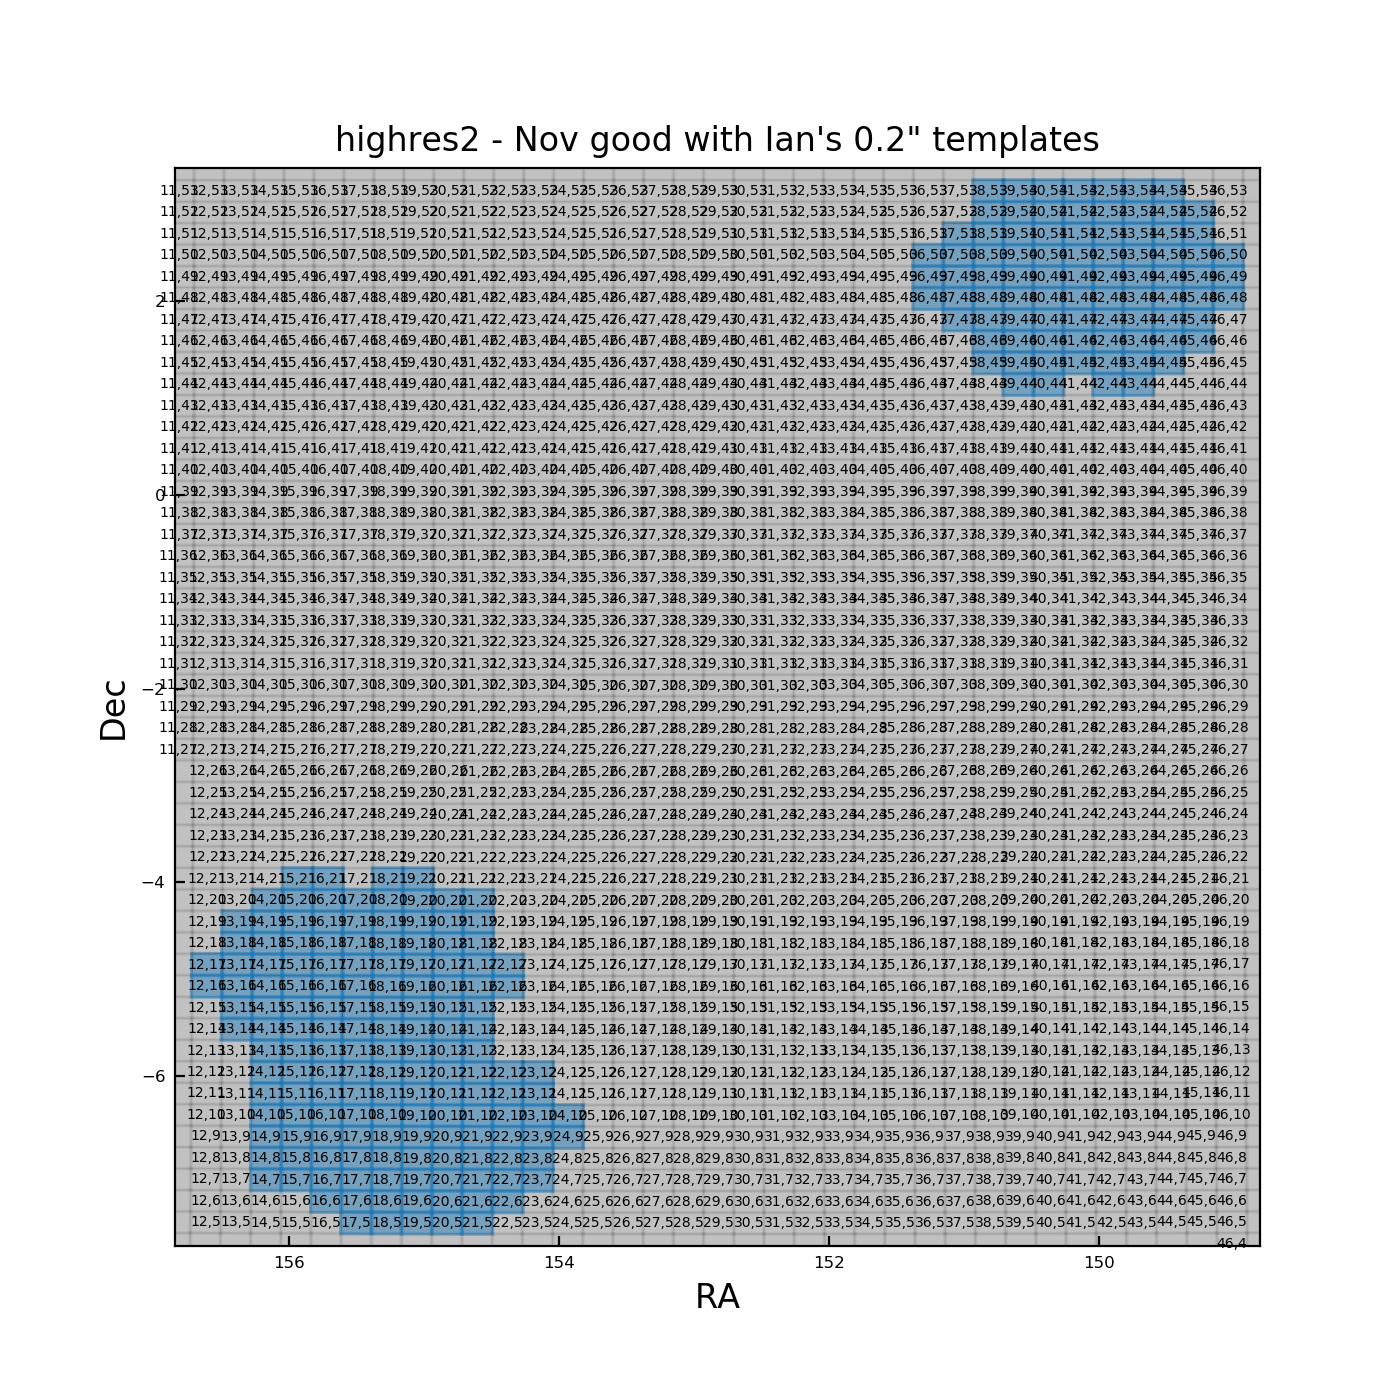

In [8]:
plotSkymap('/project/mrawls/hits2015/rerun/highres2', title='highres2 - Nov good with Ian\'s 0.2\" templates')

Above, the patches at Ian's super high resolution. You can see there are 2 overlapping HiTS fields and 1 solo field.

When I made a similar plot for the "Dec fail" rerun, I saw errant blue patches smack in the middle of the tract. I used the `printConstituents` option above to learn that these patches full of lies all had one constituent visit, and it was always 289818. I subsequently excluded those patches from the coadd assembly step.

Below, the patches at the new DECam instrument resolution.

<IPython.core.display.Javascript object>


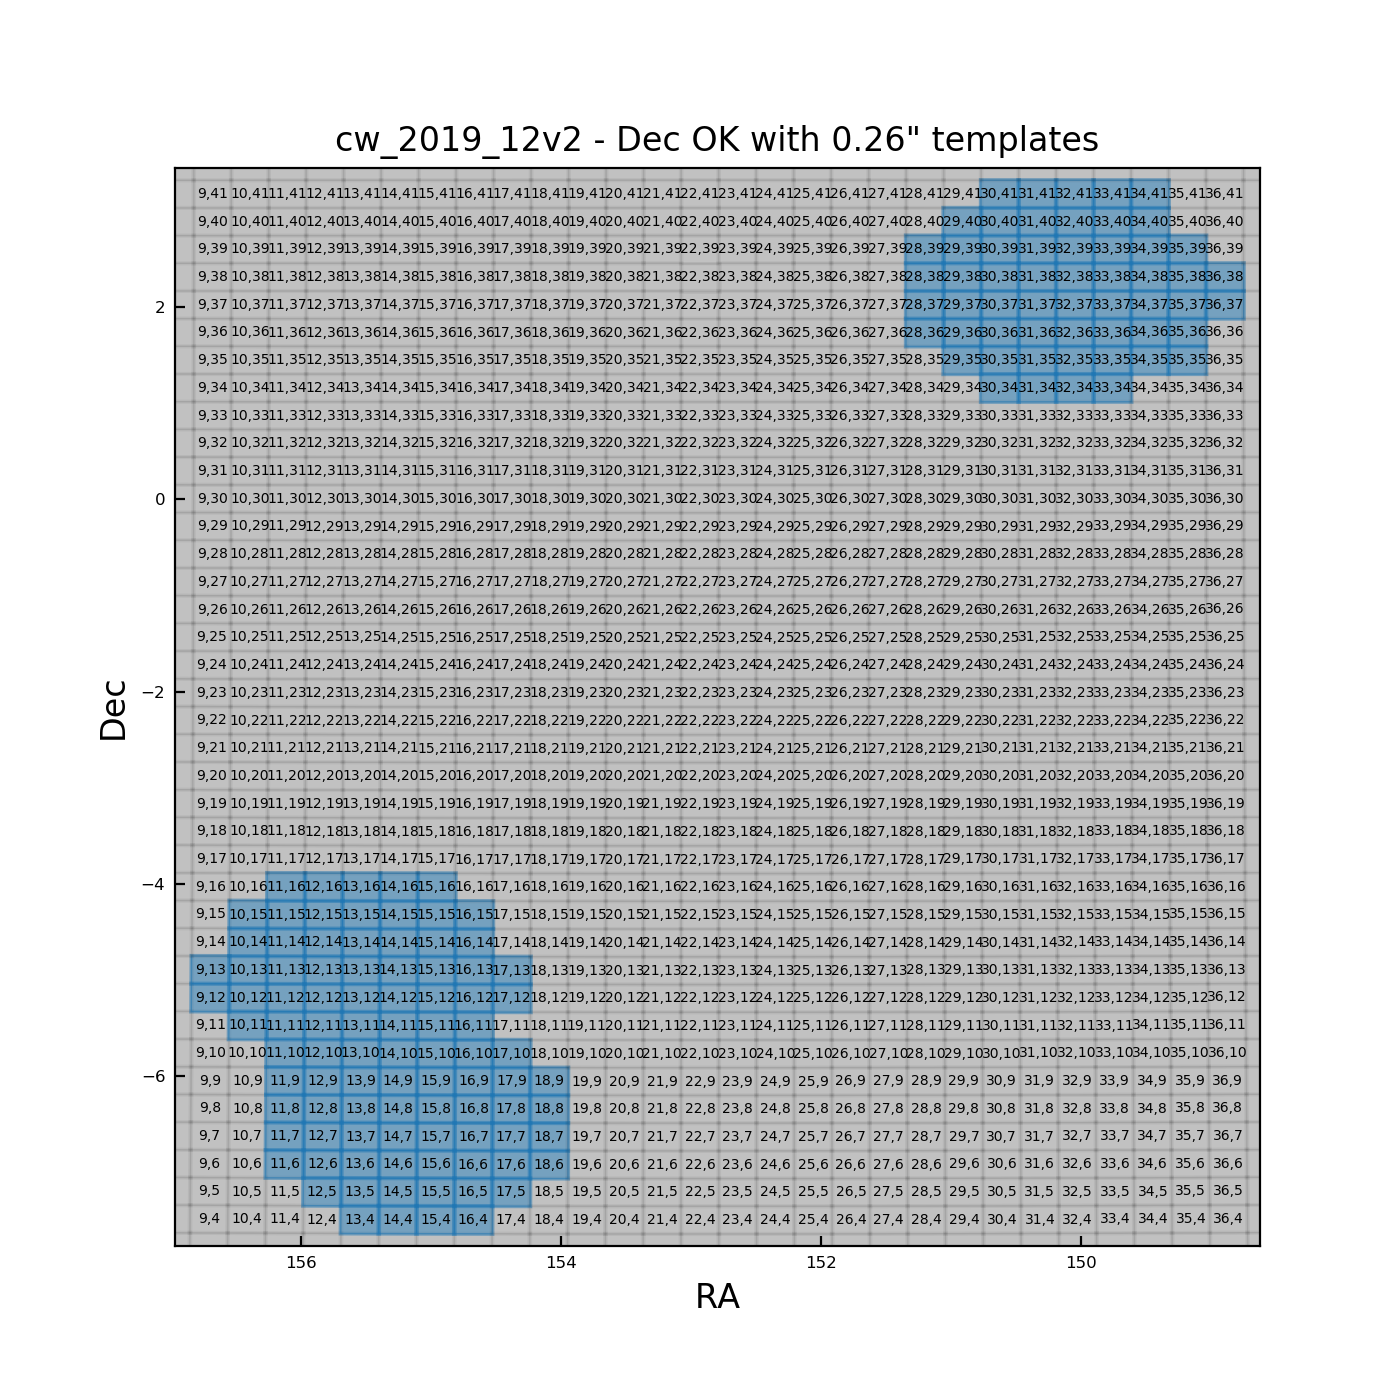

In [29]:
plotSkymap('/project/mrawls/hits2014/rerun/2019_12_coadds_full2', title='cw_2019_12v2 - Dec OK with 0.26\" templates')

In [12]:
def plotHitsSourcesOnSky(srcTable, title=None):
    fig = plt.figure(figsize=(10, 8))
    ax1 = plt.subplot2grid((100, 100), (0, 55), rowspan=50, colspan=45)  # 1 single HiTS field, on the right
    ax2 = plt.subplot2grid((100, 100), (0, 0), rowspan=90, colspan=50)  # 2 overlapping HiTS fields, on the left

    ax1Filter = (srcTable['decl'] > -2)
    ax2Filter = (~ax1Filter)

    scatter1 = ax1.scatter(srcTable.loc[ax1Filter, 'ra'],
                           srcTable.loc[ax1Filter, 'decl'], 
                           c='C0', s=2, alpha=0.2)
    scatter2 = ax2.scatter(srcTable.loc[ax2Filter, 'ra'], 
                           srcTable.loc[ax2Filter, 'decl'], 
                           c='C0', s=2, alpha=0.2)

    ax1.set_xlabel('RA (deg)')
    ax2.set_xlabel('RA (deg)')
    ax1.set_ylabel('Dec (deg)')
    ax2.set_ylabel('Dec (deg)')

    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax1.invert_xaxis()
    ax2.invert_xaxis()

    ax1.yaxis.tick_right()
    ax1.yaxis.set_label_position('right')

    plt.subplots_adjust(wspace=0.1, hspace=0)

    if title is not None:
        plt.title(title)

<IPython.core.display.Javascript object>


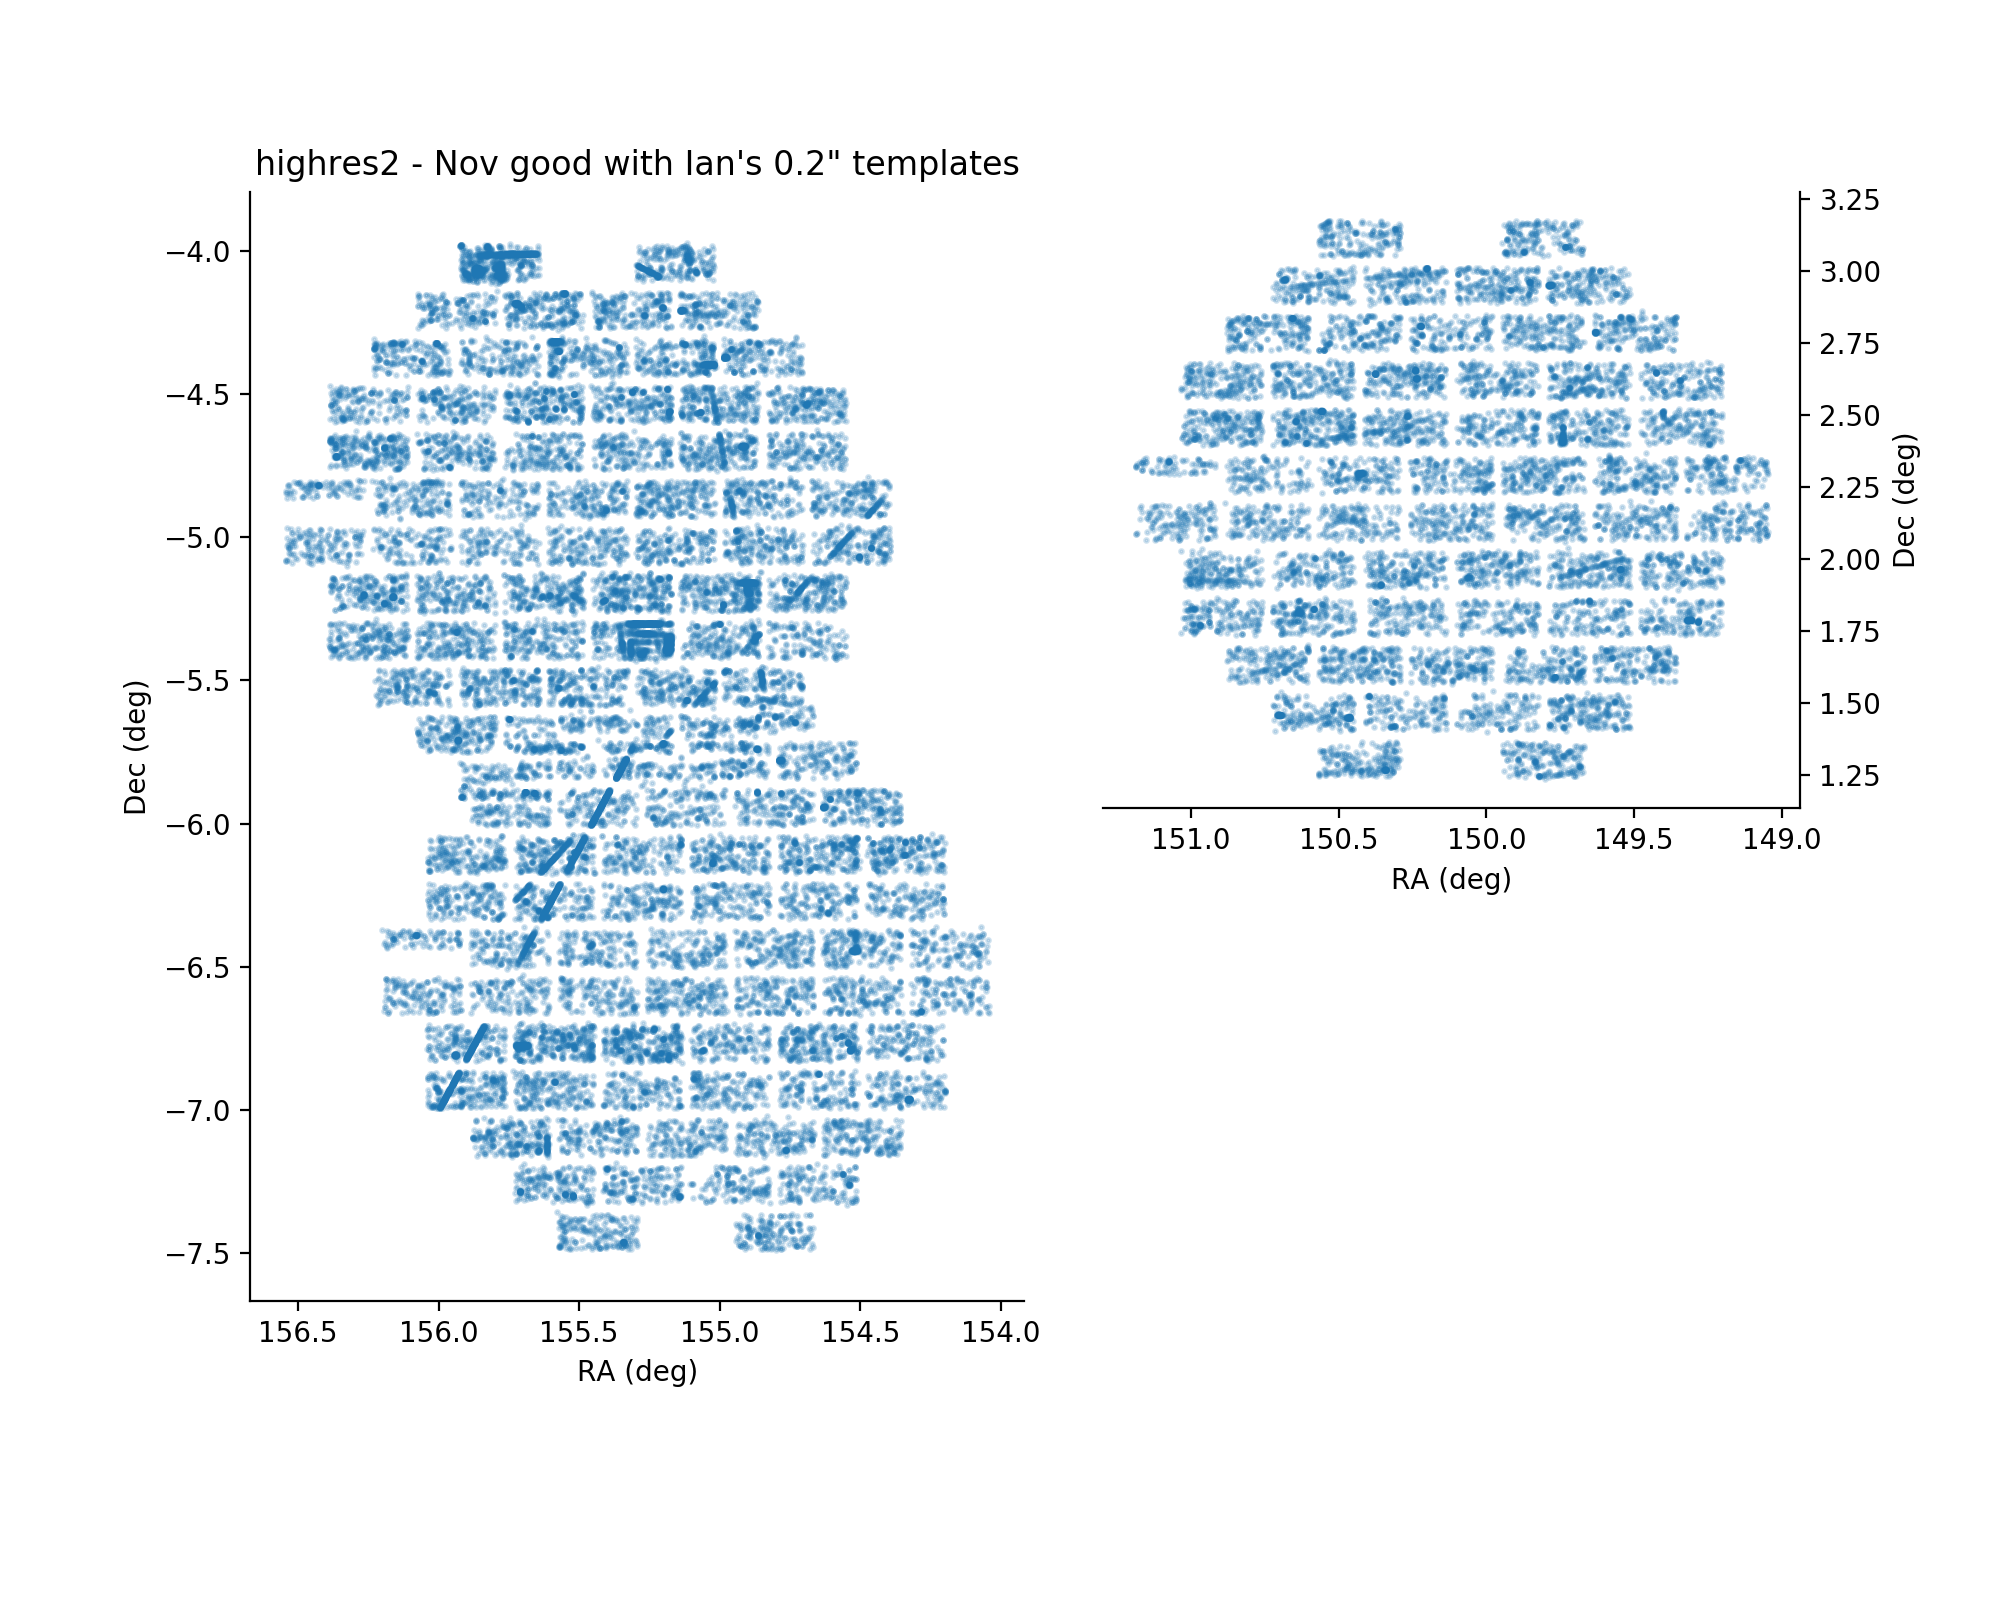

In [13]:
plotHitsSourcesOnSky(goodObj1, title='highres2 - Nov good with Ian\'s 0.2\" templates')

Above, what we are trying to reproduce, more or less.

Below, a failed attempt, due to well-intentioned parallelization of warp creation over CCD when using the good seeing selector.

<IPython.core.display.Javascript object>


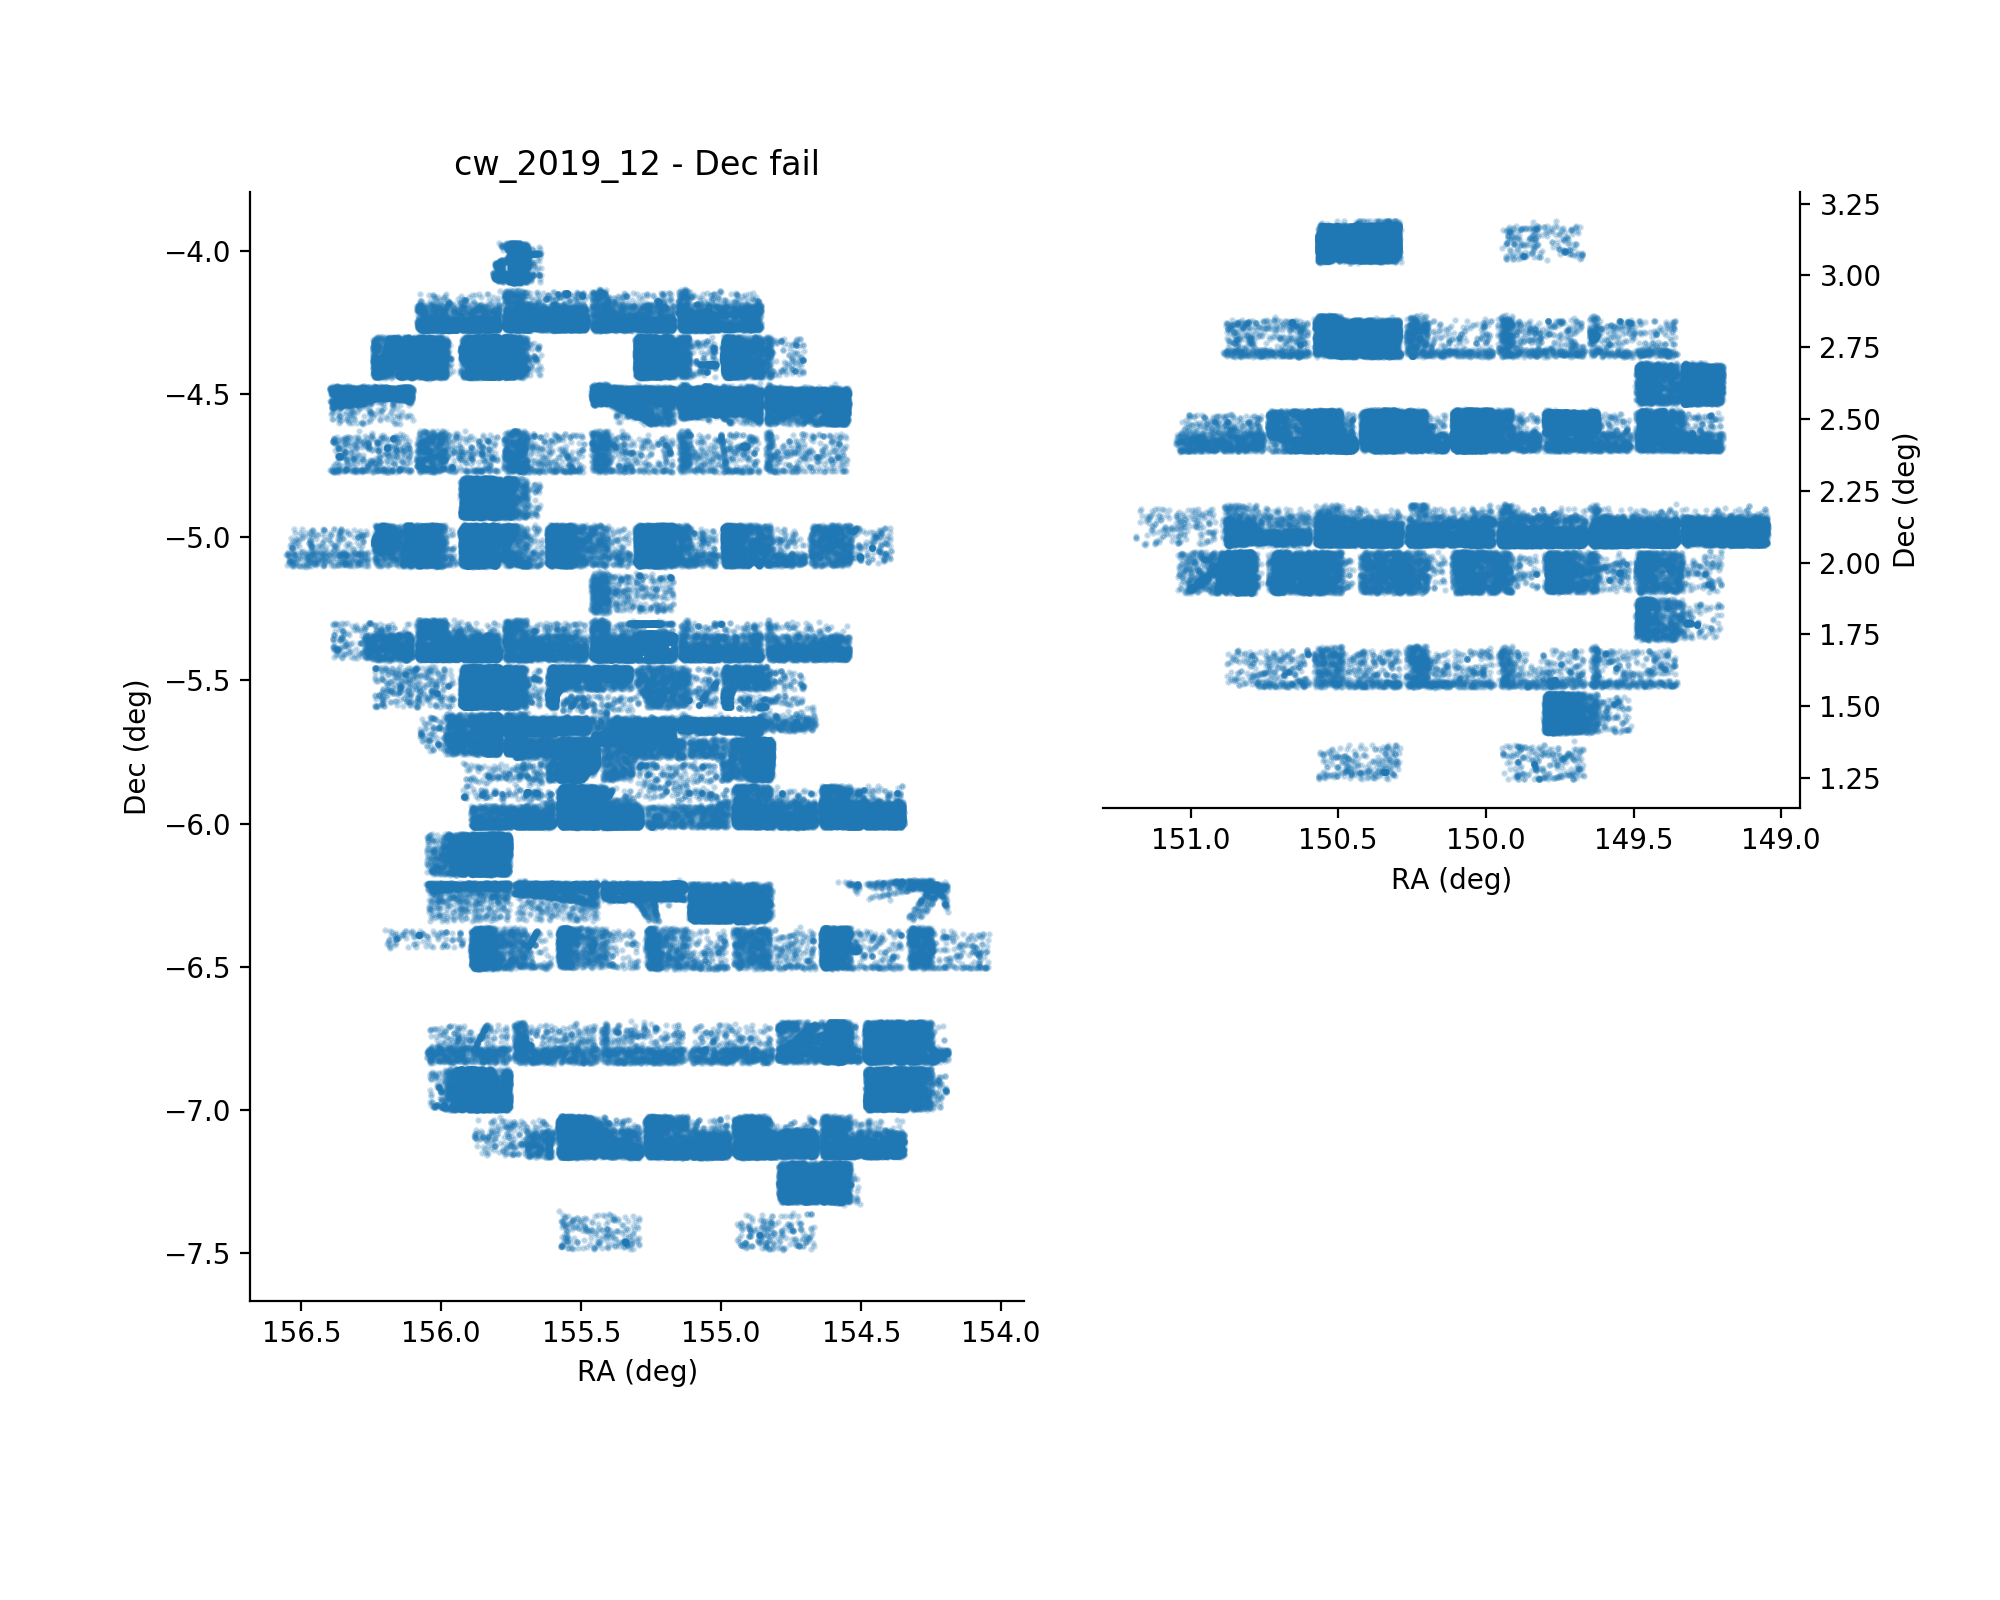

In [14]:
plotHitsSourcesOnSky(goodObj2, title='cw_2019_12 - Dec fail')

<IPython.core.display.Javascript object>


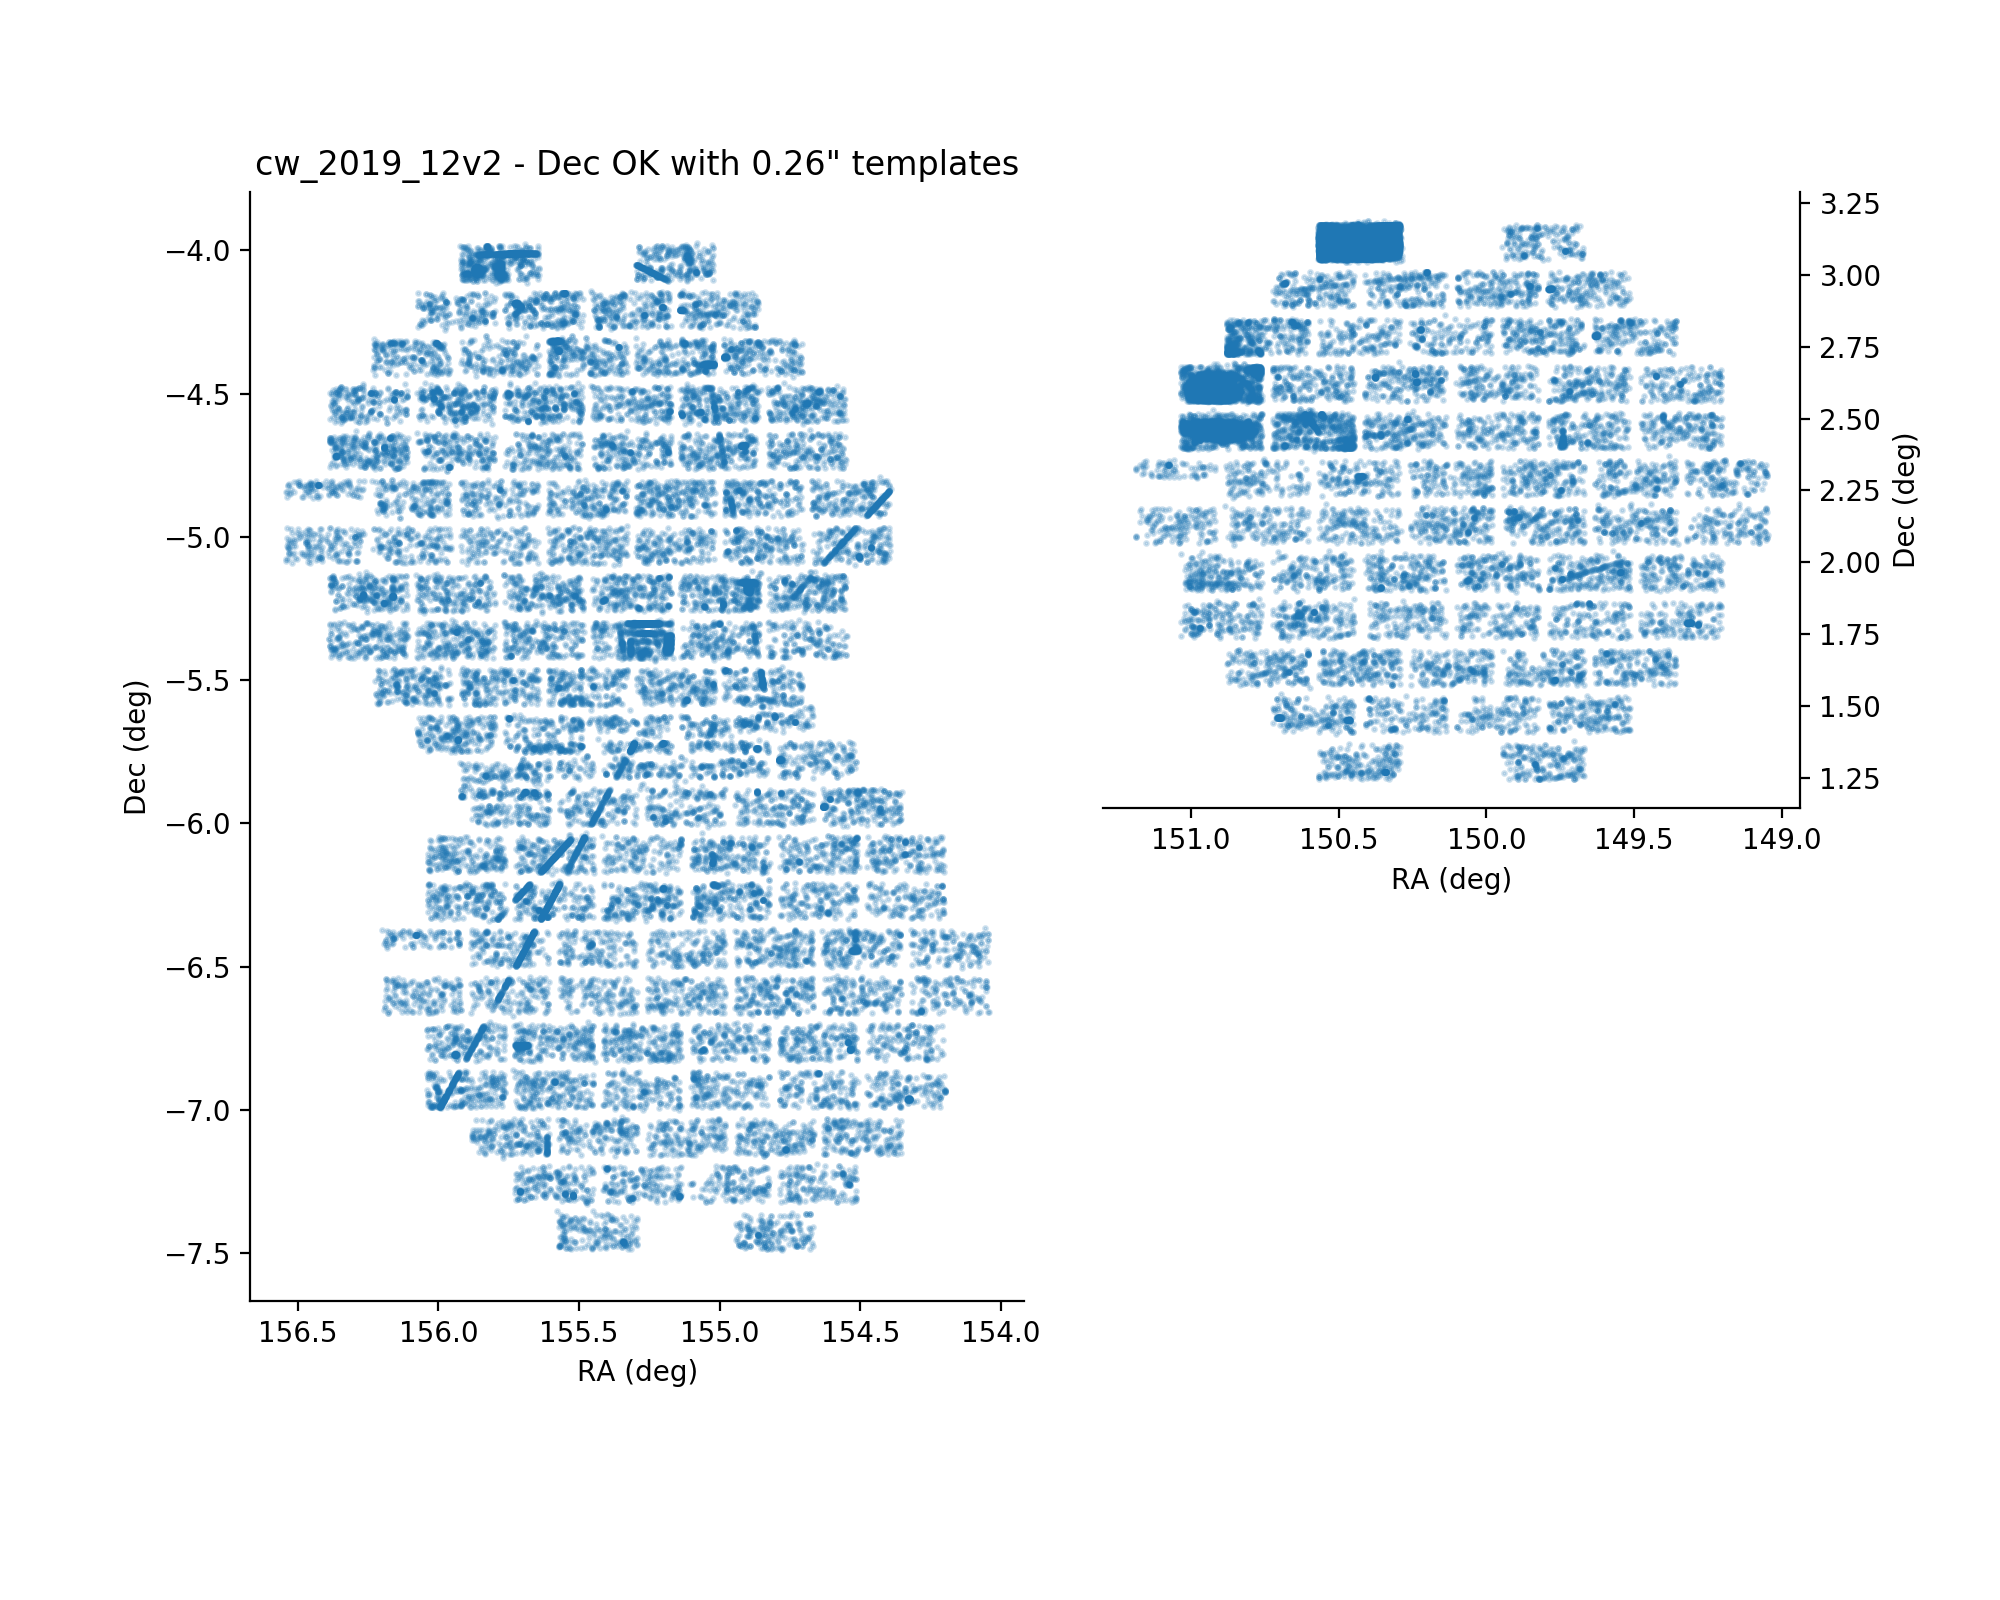

In [15]:
plotHitsSourcesOnSky(goodObj3, title='cw_2019_12v2 - Dec OK with 0.26\" templates')

That's better!!! (except for maybe a few CCDs?)

### What happened in "Dec fail"?

The good seeing selector is not really parallelizable at present. So when I tried to use slurm to loop over ccd to make warps (which is one of the first steps in making templates), it did not guarantee that every part of the field had any selected data in it.

It's not clear to me why there are **way more** sources than there should be throughout the populated regions of the "Dec fail" rerun, but it looks like some kind of background fitting failure.

To make the "Dec OK" rerun, I let the warp creation step work on 1–2 entire HiTS fields at once. This is slow, but it ensured something was selected everywhere there is data. For unclear reasons, it seems to have chosen most/all of the visits as acceptable (20–21 of 21 available). There are 3–4 CCDs in the solo field where the issue seen before - loads of spurious sources - still appear. The variance in the coadd is very low (about a factor of 3 lower than OK regions) but the coadds themselves do not look suspicious in those regions. More work will be needed to investigate what happened.

In [19]:
def plotHistogram(objTable, goodObj, title=None):
    plt.figure(figsize=(8, 6))
    plt.xlabel('Number of DIASources per DIAObject', size=12)
    plt.ylabel('DIAObject count', size=12)
    plt.ylim(0.7, 1e5)
    plt.yscale('log')
    plt.hist(objTable['nDiaSources'].values, bins=np.arange(0, 60), color='#2979C1', label='All Objects')
    plt.hist(goodObj['nDiaSources'].values, bins=np.arange(0, 60), color='#Bee7F5', label='Filtered Objects')
    plt.legend(frameon=False, fontsize=12)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

<IPython.core.display.Javascript object>


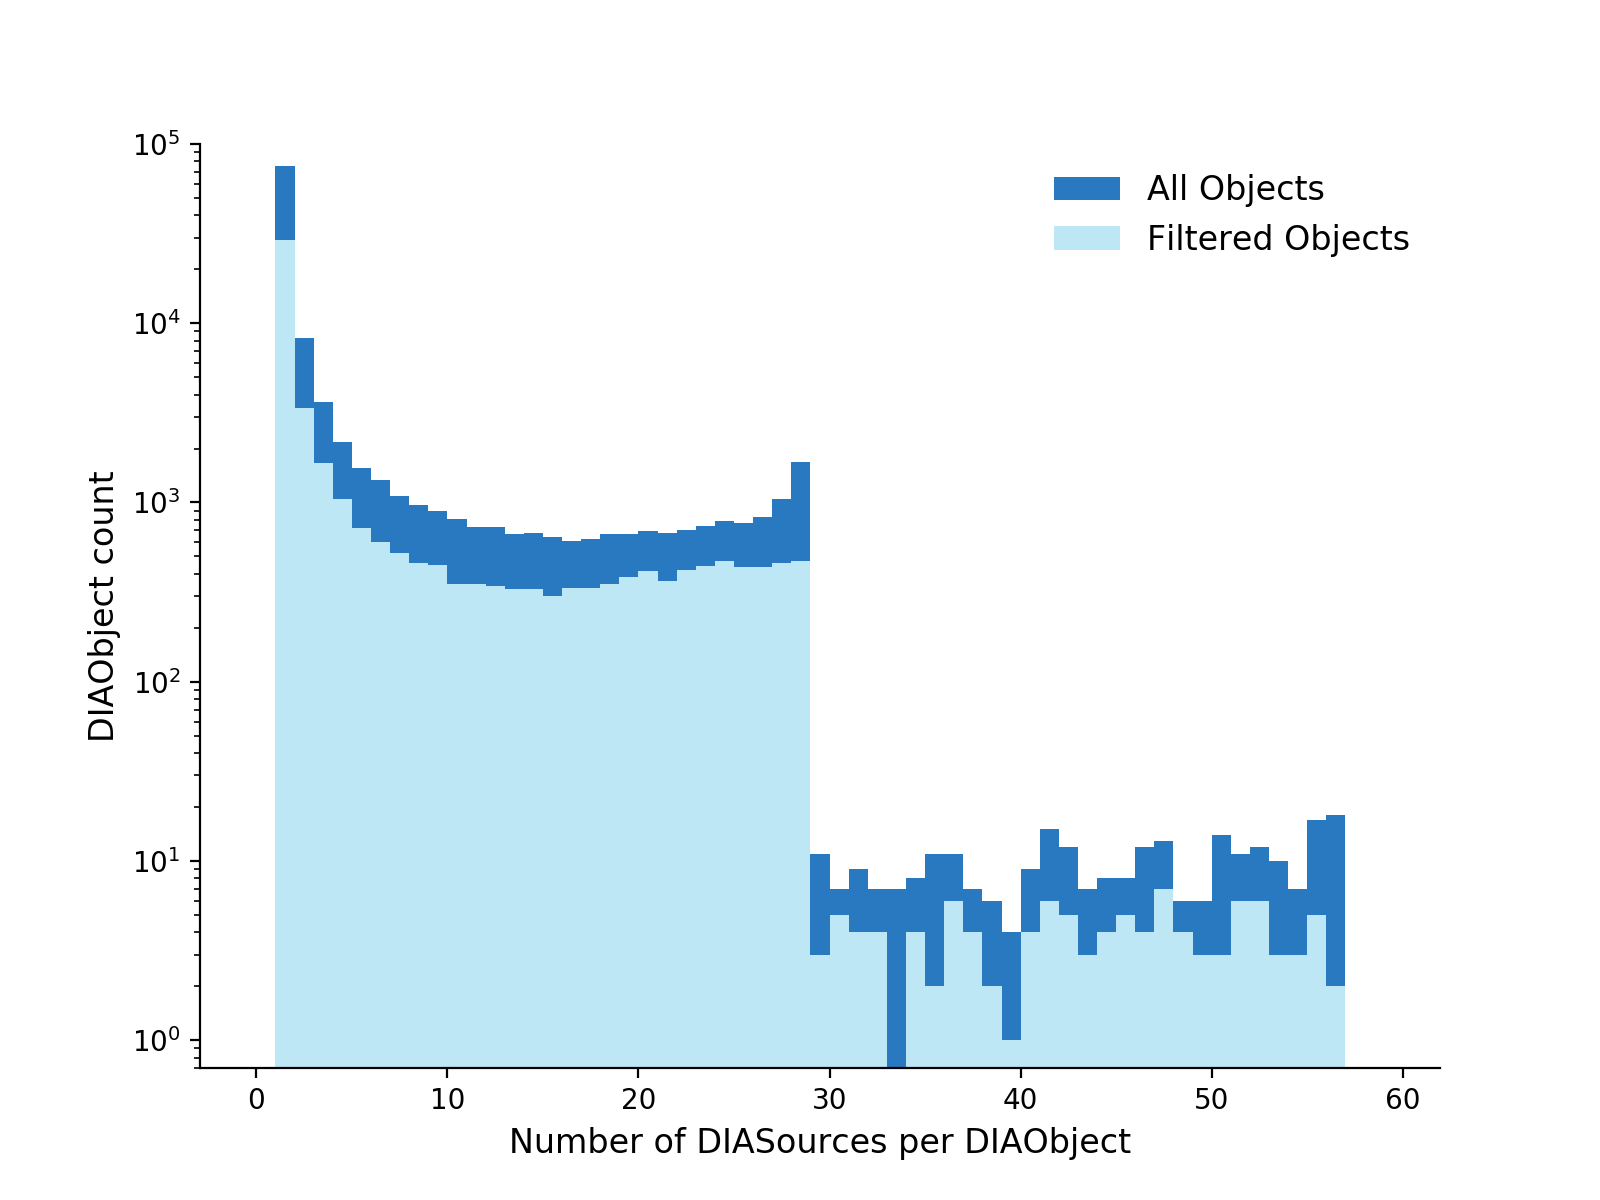

In [20]:
plotHistogram(objTable1, goodObj1, title='highres2 - Nov good with Ian\'s 0.2\" templates')

<IPython.core.display.Javascript object>


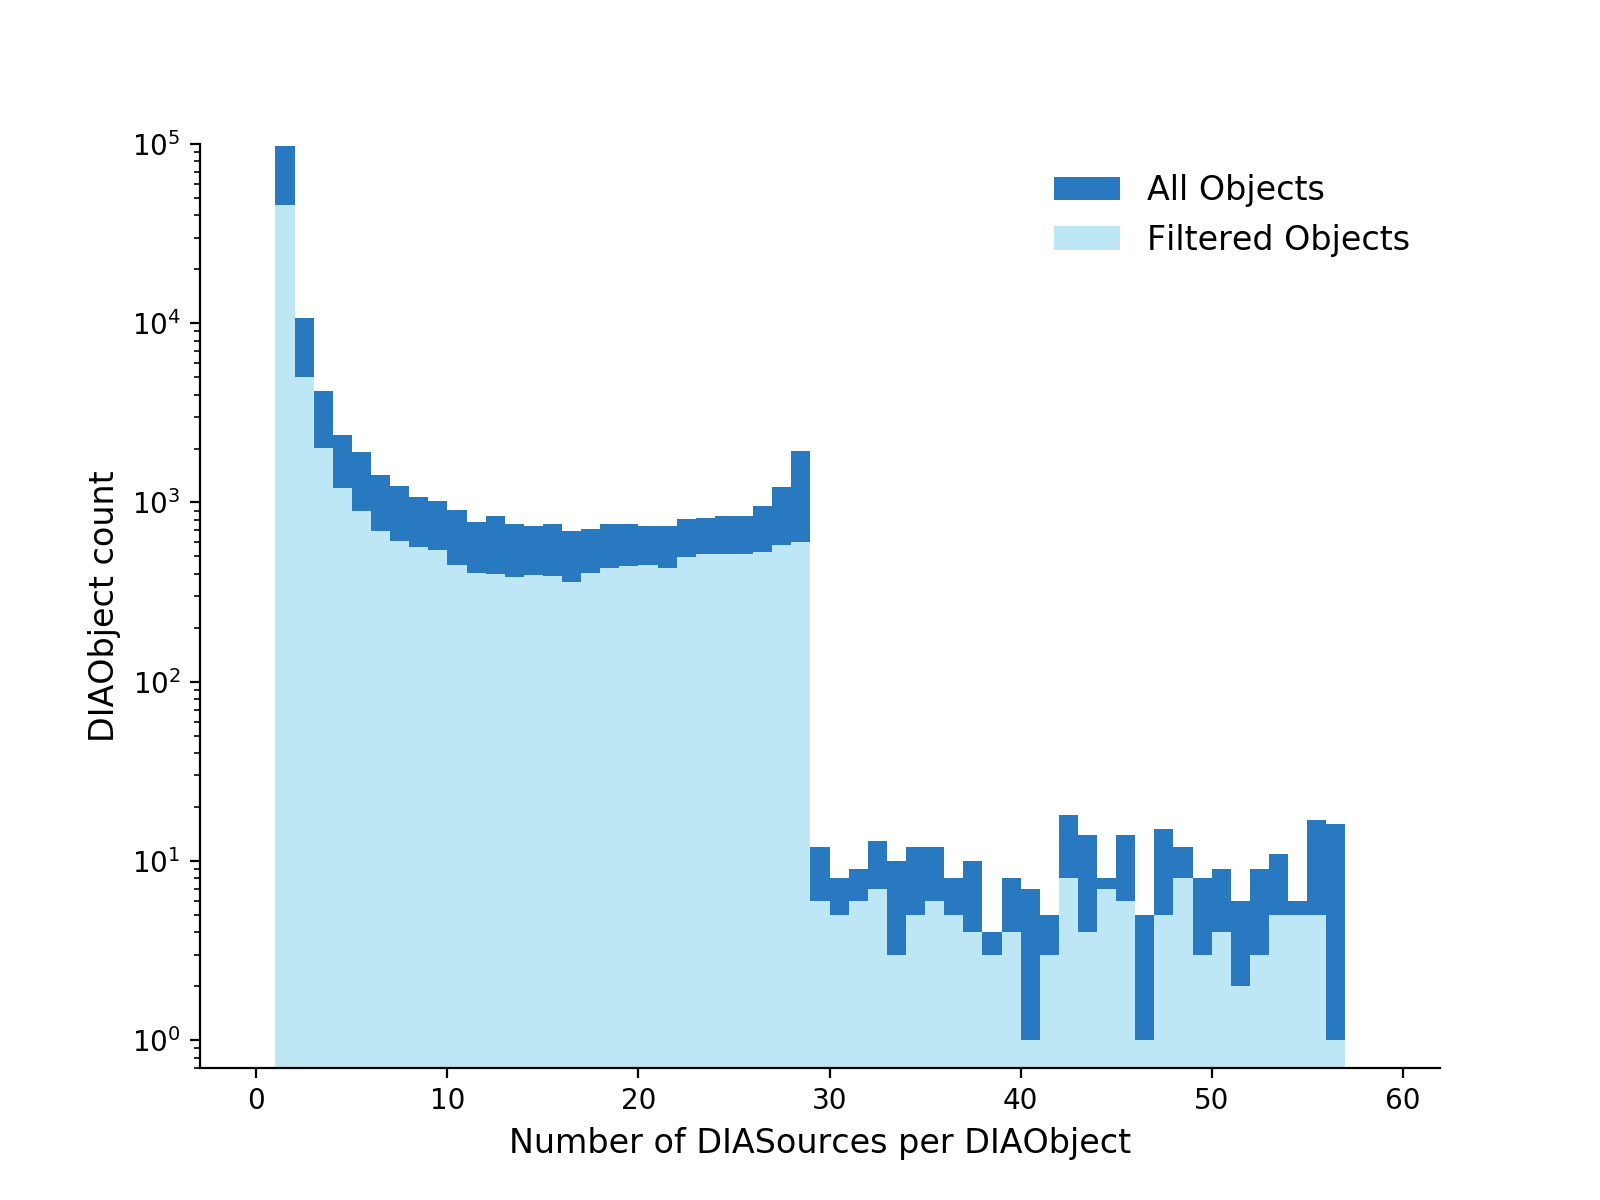

In [22]:
plotHistogram(objTable3, goodObj3, title='cw_2019_12v2 - Dec OK with 0.26\" templates')

In [25]:
print(len(goodSrc1), len(goodSrc3))

201400 252148


In [32]:
print(len(objTable1), len(objTable3))

110405 138736
